In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import  sem, t, kstest, anderson, chisquare, norm, shapiro
from scipy.optimize import curve_fit, minimize, linprog, minimize_scalar
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import os
import glob
import math

In [11]:
# Plot Widths
chan_w = 1
cos_w = 1.25
# Plot styles {- solid | : dotted | -- dashed | -. dashdot}
none_style = '-'
diff_style = '-'
# Channel Colours (based on https://405nm.com/wavelength-to-color/)
f1_colour = '#7600ed'       # λ = 415nm
f1_colour_dark = '#5300a5'  # λ = 415nm, 30% darker
f1_colour_light = '#a020ff' # λ = 415nm, 30% lighter
f2_colour = '#0028ff'       # λ = 445nm
f2_colour_dark = '#001eb2'  # λ = 445nm, 30% darker
f2_colour_light = '#0036ff' # λ = 445nm, 30% lighter
f3_colour = '#00d5ff'       # λ = 480nm
f3_colour_dark = '#0098b2'  # λ = 480nm, 30% darker
f3_colour_light = '#19ffff' # λ = 480nm, 30% lighter
f4_colour = '#1fff00'       # λ = 515nm
f4_colour_dark = '#17b200'  # λ = 515nm, 30% darker
f4_colour_light = '#29ff00' # λ = 515nm, 30% lighter
f5_colour = '#b3ff00'       # λ = 555nm
f5_colour_dark = '#7eb200'  # λ = 555nm, 30% darker
f5_colour_light = '#dcff19' # λ = 555nm, 30% lighter
f6_colour = '#ffdf00'       # λ = 590nm
f6_colour_dark = '#b2a500'  # λ = 590nm, 30% darker
f6_colour_light = '#fff719' # λ = 590nm, 30% lighter
f7_colour = '#ff4f00'       # λ = 630nm
f7_colour_dark = '#b23800'  # λ = 630nm, 30% darker
f7_colour_light = '#ff6733' # λ = 630nm, 30% lighter
f8_colour = '#df0000'       # λ = 680nm
f8_colour_dark = '#9f0000'  # λ = 680nm, 30% darker
f8_colour_light = '#ff3333' # λ = 680nm, 30% lighter

fr1  = '#344a9a'    # freiburg logo blue
fr1a = '#868dc2'    # freiburg logo blue (lighter)
fr1b = '#afb1d8'    # freiburg logo blue (lightest)
fr1c = '#00004a'    # freiburg logo blue (darker)
fr2  = '#93bc3c'    # ecosense green
fr2a = '#c1e653'    # ecosense green (lighter)
fr2a = '#659023'    # ecosense green (darker)
fr3  = '#00a082'    # freiburg teal
fr4  = '#f5c2cd'    # freiburg pink
fr5  = '#ffe863'    # freiburg yellow
fr6  = '#8f6b30'    # freiburg brown
# Measurement Markers {'none' none | 'o' circle | '^' triangle | 's' square |'X' X | '+' plus}
f1_mark = 'o'       # λ = 415nm
f2_mark = 'o'       # λ = 445nm
f3_mark = 'o'       # λ = 480nm
f4_mark = 'o'       # λ = 515nm
f5_mark = 'o'       # λ = 555nm
f6_mark = 'o'       # λ = 590nm
f7_mark = 'o'       # λ = 630nm
f8_mark = 'o'       # λ = 680nm
# Marker Edge Colour {'black' | 'face'}
edges = 'face'
# Marker Transparency {0: fully transparent, 1: fully opaque}
malpha= 0.75
# Marker Size
mark_sz = 3
# Marker Frequency
mark_freq = 7
# Error Bar Line Width
elw = 7
# Error Bar Capsize
ecs = 1
# Error Bar Cap Style
err_cap_style = 'round'
# graph fonts
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

Change sensor number:

In [26]:
path = r"../data"

sensor = 2

save = False

file = f"/Sensor{sensor}_preprocessed_normed+mean.csv"

df_all = pd.read_csv(path+file, delimiter=",")
df_all = df_all.sort_values(by='wavelength')
df_all = df_all.reset_index(drop=True)
df_all = df_all[df_all["wavelength"] <= 1100]

In [27]:
planck = (6.626e-34)
c_light = (3.0e8)
avogadro = 6.02214076e23

df_all['PAR_slope'] = (df_all['wavelength']/10E9).astype(float) / (planck * c_light) * ((1e6)/(avogadro))
df_all.loc[(df_all['wavelength'] < 401) | (df_all['wavelength'] > 700), 'PAR_slope'] = 0
df_all['PAR_slope'] = df_all['PAR_slope']/df_all['PAR_slope'].max()

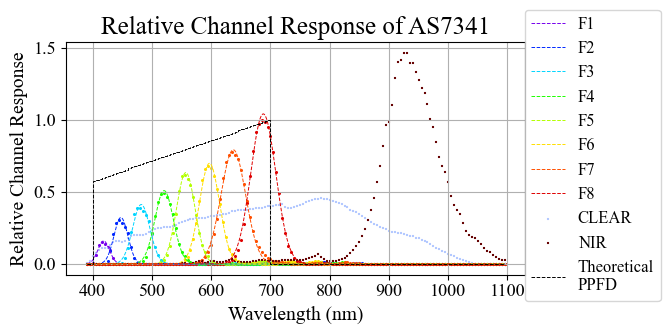

In [28]:
# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Gaussian fit for F1 to F8
channels = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8"]
colors = [f1_colour, f2_colour, f3_colour, f4_colour, f5_colour, f6_colour, f7_colour, f8_colour]
fits = {}
mark_sz = 1.5
plt.rcParams.update({'font.size': 14})

#fig, ax = plt.subplots()
plt.figure(figsize=([7,3.5]))
for channel, color in zip(channels, colors):
    x = df_all["wavelength"].values
    y = df_all[channel].values/df_all["f8"].max()

    A_guess = max(y)
    mu_guess = x[np.argmax(y)]  # x corresponding to max y
    sigma_guess = (max(x) - min(x)) / 6
    p0 = [A_guess, mu_guess, sigma_guess]
    
    try:
        # Gaussian fit with bounds and higher maxfev
        popt, _ = curve_fit(
            gaussian, x, y, p0=p0, 
            bounds=([0, min(x), 0], [np.inf, max(x), np.inf]),  # A > 0, mu in [min, max], sigma > 0
            maxfev=5000  # Increase maximum iterations
        )
        fits[channel] = popt
        # Plot scatter
        plt.scatter(x, y,  color=color, s=mark_sz, marker=f1_mark)
        # Plot Gaussian fit
        x_fit = np.linspace(min(x), max(x), 500)
        plt.plot(x_fit, gaussian(x_fit, *popt), label=channel.upper(), color=color, linestyle='--',linewidth=0.7)
    except RuntimeError as e:
        print(f"Gaussian fit failed for {channel}: {e}")
        plt.scatter(x, y, label=f"{channel.upper()} (fit failed)", color=color, s=mark_sz, marker=f1_mark)

# Moving average for Clear and NIR
for channel, color in zip(["clear", "nir"], ["#b4c9ff", "#670505"]):
    x = df_all["wavelength"].values
    y = df_all[channel].values/df_all["f8"].max()
    y_smooth = pd.Series(y).rolling(window=30, center=True).mean()  # Moving average with a window of 10
    # Plot scatter
    plt.scatter(x, y, color=color, s=mark_sz, marker='+', label=channel.upper())


plt.step(df_all['wavelength'], df_all['PAR_slope'], linestyle='--',linewidth=0.7, label=f'Theoretical\nPPFD', color="black")

plt.grid()
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Relative Channel Response', fontsize=14)
plt.title('Relative Channel Response of AS7341', fontsize=18)
#plt.xlim([395,755])
plt.legend(loc='lower left' , bbox_to_anchor=[0.98, -0.150], fontsize=12)
plt.tight_layout()
if save:
    plt.savefig(f'AS7341_channels_sensor{sensor}.png', dpi=600)

In [29]:
# for sensor 1 - 5
coeff = [[59.92668374, 24.70718793, 21.50766171, 17.24354495, 13.39451792,
        11.8149519 , 12.42065147, 10.46900328, -4.17094332,  0.40111009],
         [41.86399088, 20.21569544, 17.18351837, 14.01046588, 11.92773693,
        10.18018347, 10.98293021,  7.31224259, -2.55458134,  0.12996009],
         [40.51810537, 20.1008011 , 16.17535968, 13.99764274, 12.79404106,
         9.10957889, 11.71243518,  6.40883644, -2.72641955,  0.13235224],
         [53.71094296, 27.20840478, 20.90555965, 16.79546788, 13.58586488,
        10.05197618, 14.67125543,  8.94969782, -2.74596992,  0.33522009],
         [55.70132991, 27.74109045, 20.08749703, 16.80971311, 16.73067431,
        12.930032  , 15.15224572, 10.11805387, -2.08180868,  0.16131638]]

In [30]:
df_single = df_all.copy()
df_single = df_single[df_single["wavelength"] <= 1100]

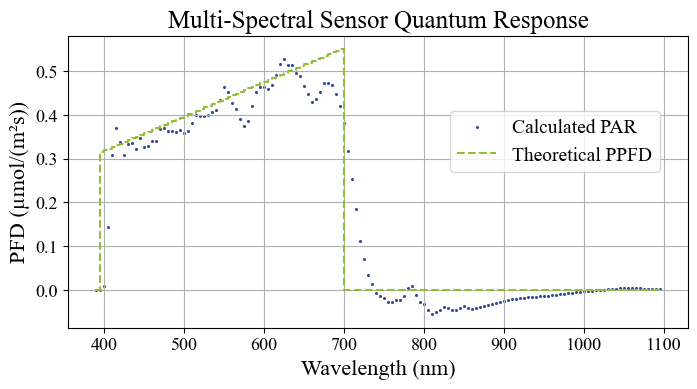

In [31]:
plt.figure(figsize=[8,4])

df_single["PAR_calculated"]=df_single[["f1","f2","f3","f4","f5","f6","f7","f8","clear","nir"]].mul(coeff[sensor-1], axis=1).sum(axis=1)

plt.scatter(df_single["wavelength"], df_single["PAR_calculated"], label='Calculated PAR', color=fr1, s=mark_sz, marker=f1_mark)
plt.step(df_single['wavelength'], df_single['PAR'], linestyle='--', label=f'Theoretical PPFD', color=fr2)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 18

plt.grid()
plt.xlabel('Wavelength (nm)')
plt.ylabel('PFD (µmol/(m²s))')
plt.title(' ')
plt.title('Multi-Spectral Sensor Quantum Response')
plt.legend(loc = "lower left", bbox_to_anchor=(0.6,0.5))

plt.subplots_adjust(bottom=0.15)
if save:
    plt.savefig(f'means_sensor{sensor}.png', dpi=600)

In [32]:
r2_score(df_single['PAR'], df_single['PAR_calculated'])

0.9245555502166587